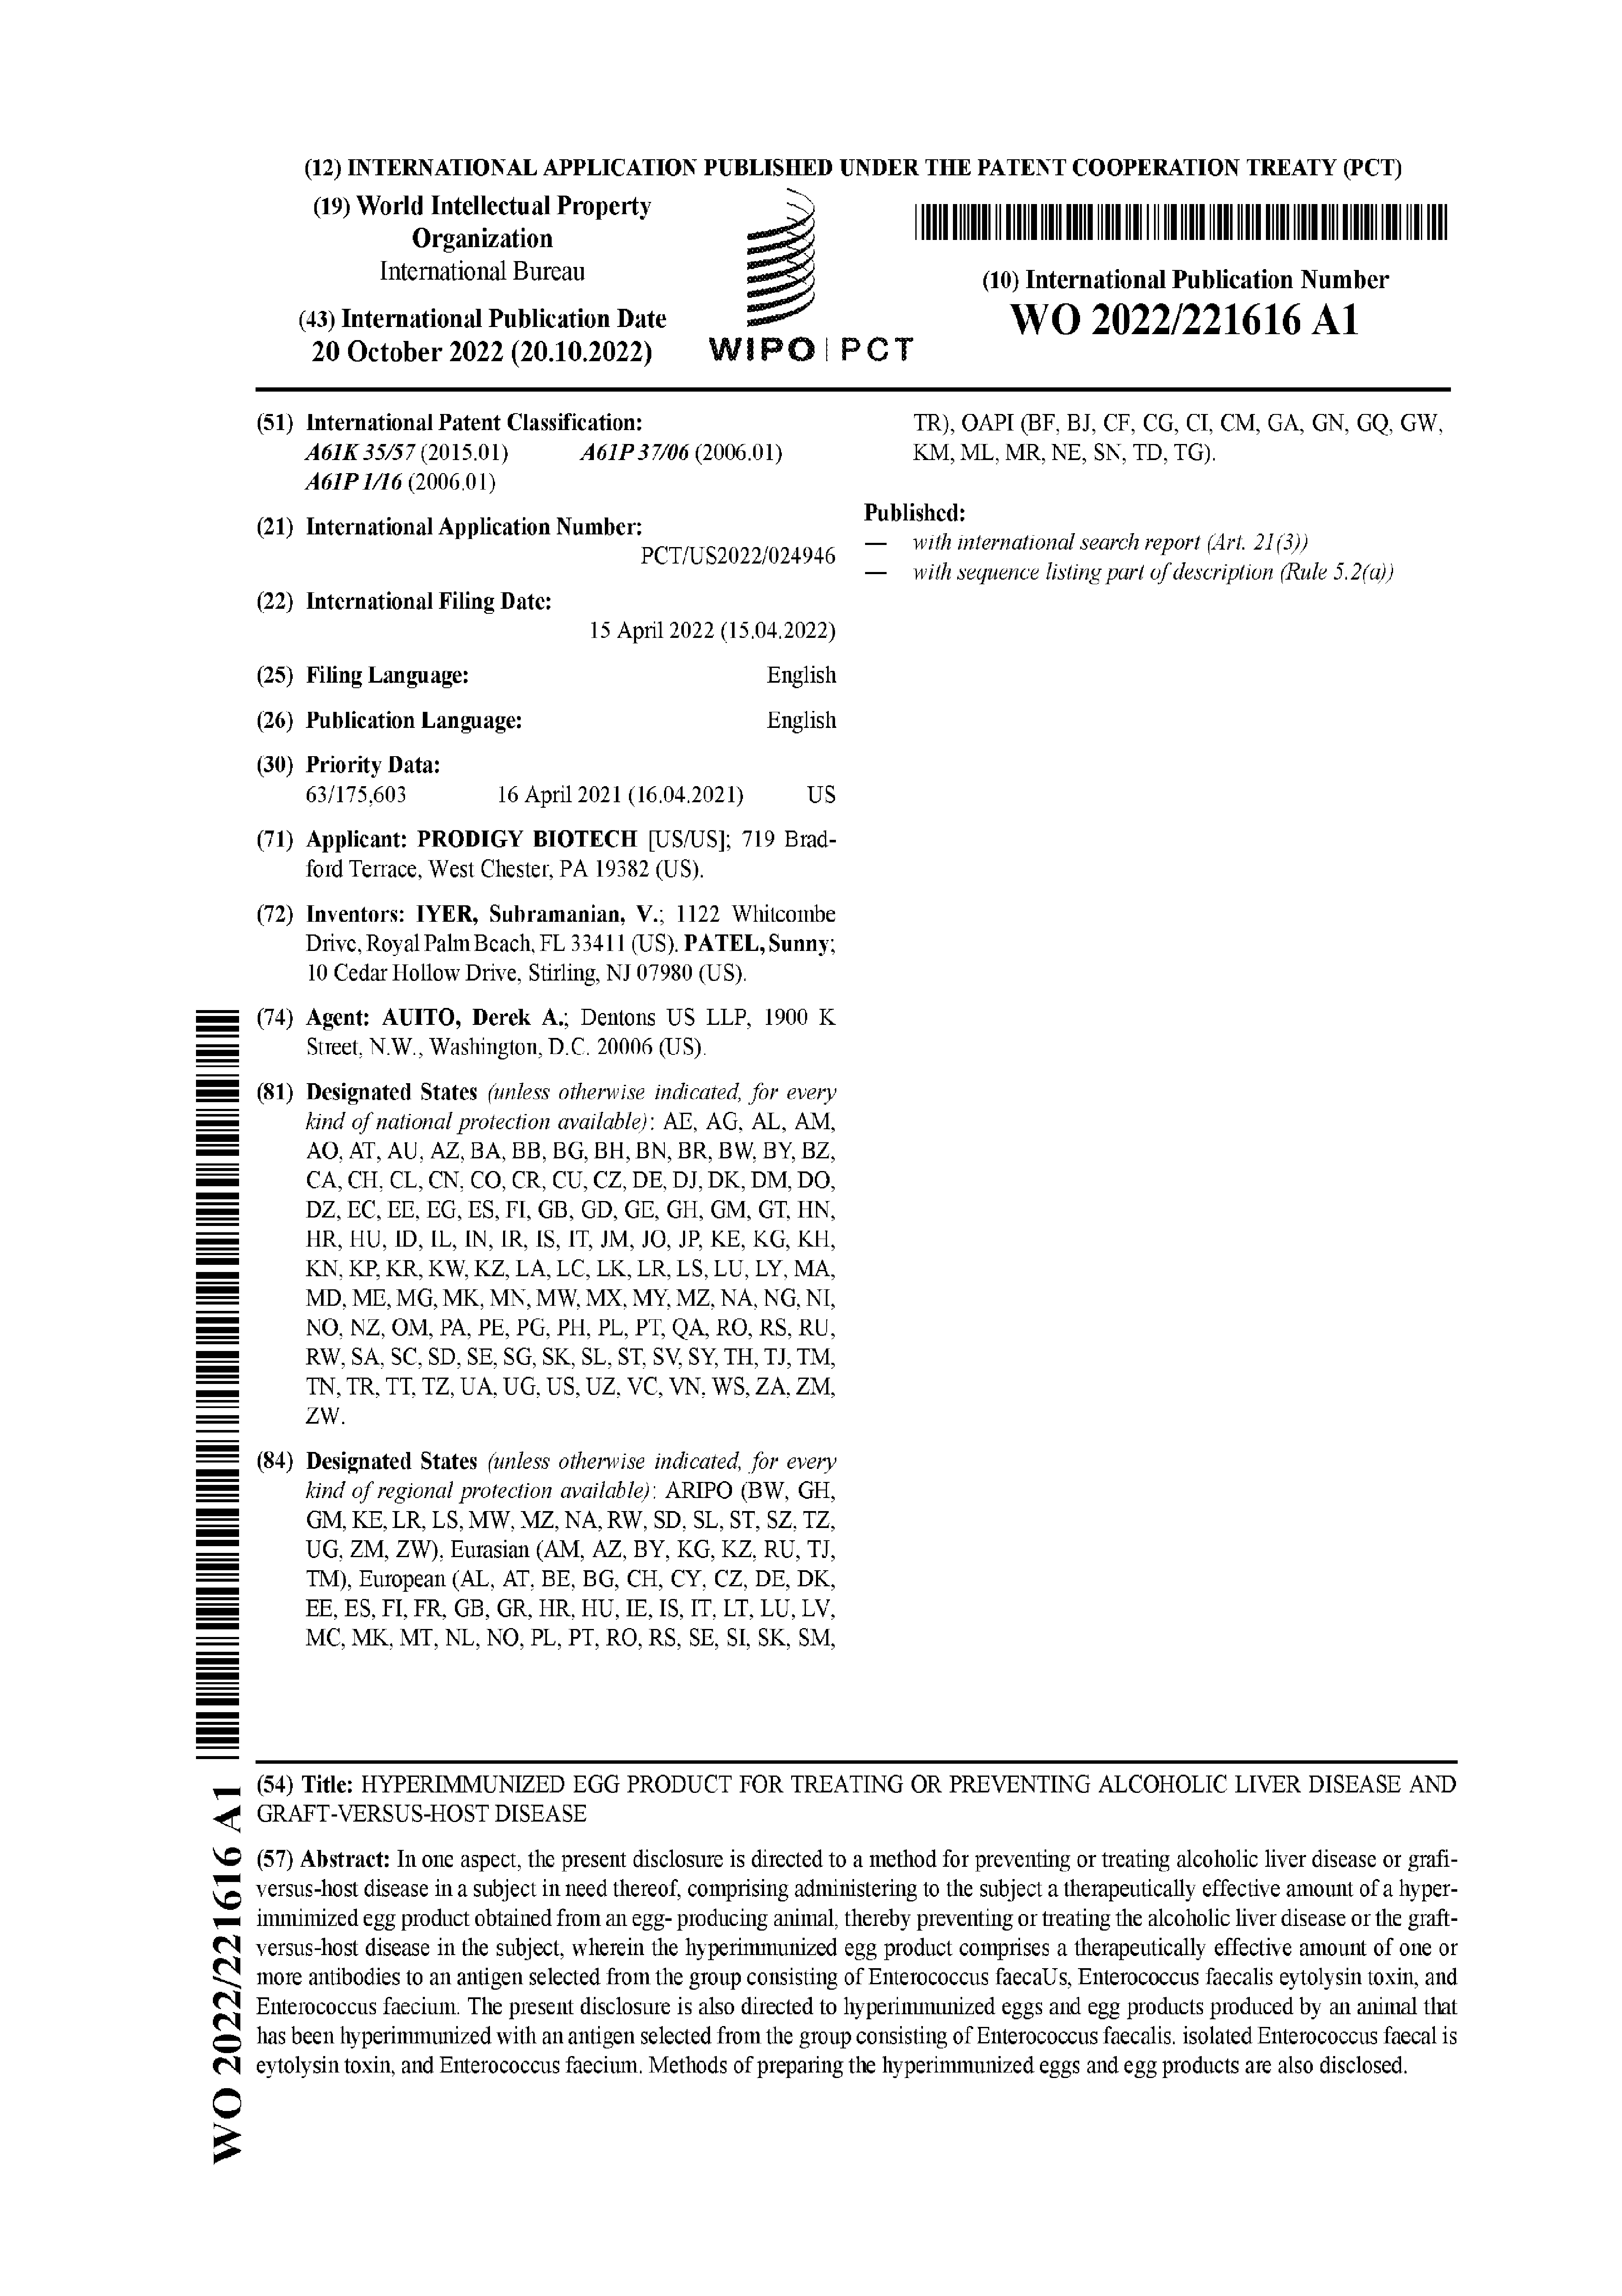

In [5]:
import pdfplumber
from PIL import Image
from IPython.display import display

def get_page():
    with pdfplumber.open(rf'C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf') as pdf:
        first_page = pdf.pages[0]
        return first_page
    
page = get_page()
page_image = page.to_image(width=3840).original
display(page_image)

In [6]:
import pprint

def get_page_text():
    with pdfplumber.open(rf'C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf') as pdf:
        first_page = pdf.pages[0]
        return first_page.extract_text(keep_blank_chars=True)
    
page_text = get_page_text()

pprint.pprint("Extracted Text: " + page_text)

'Extracted Text: '


In [7]:
import pytesseract

def get_page_ocr():
    with pdfplumber.open(rf'C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf') as pdf:
        first_page = pdf.pages[0]
        return pytesseract.image_to_string(first_page.to_image(width=1920).original, output_type='string')
    
page_ocr = get_page_ocr()

pprint.pprint(page_ocr)

('WO 2022/221616 AL IMT UNITARIAN MAA\n'
 '\n'
 "(12) INTERNATIONAL APPLICATION PUBLISHED UNDER THE PATEN'T COOPERATION "
 'TREATY (PCT)\n'
 '\n'
 '™\n'
 'ey\n'
 '\n'
 'a\n'
 '\n'
 '(19) World Intellectual Property\n'
 'Organization\n'
 'International Bureau\n'
 '(43) International Publication Date\n'
 '20 October 2022 (20.10.2022)\n'
 '\n'
 '(51) International Patent Classification:\n'
 '\n'
 'A61K 35/57 (2015.01) A61P 37/06 (2006.01)\n'
 'A6IP 1/16 (2006.01)\n'
 '(21) International Application Number:\n'
 'PCT/US2022/024946\n'
 '(22) International Filing Date:\n'
 '15 April 2022 (15.04.2022)\n'
 '(25) Filing Language: English\n'
 '(26) Publication Language: English\n'
 '\n'
 '(30) Priority Data:\n'
 '\n'
 '63/175,603 16 April 2021 (16.04.2021) US\n'
 '\n'
 '(71) Applicant: PRODIGY BIOTECTI [US/US]; 719 Brad-\n'
 'ford Terrace, West Chester, PA 19382 (US).\n'
 '\n'
 '(72) Inventors: LYER, Subramanian, ¥.; 1122 Whitcombe\n'
 'Drive, Roval Palm Beach, FL 33411 (US), PATEL, Sunny;\n'
 '1

In [8]:
import io
import base64
from openai import OpenAI

client = OpenAI()

def get_image():
    with pdfplumber.open(rf'C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf') as pdf:
        first_page = pdf.pages[0]
        return first_page.to_image(width=1920).original

# Function to encode the image
def encode_ocr_image():
    with pdfplumber.open(rf'C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf') as pdf:
        pil_img = pdf.pages[0].to_image(width=1920).original
    buffer = io.BytesIO()    
    pil_img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")
    
base64_image = encode_ocr_image()


completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                { "type": "text", "text": "You are a Vision OCR Model, extract all text to the best of your ability, do not add any other comments or words to your response" },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "high",
                    },
                },
            ],
        }
    ],
)

pprint.pprint(completion.choices[0].message.content)

('```\n'
 '(12) INTERNATIONAL APPLICATION PUBLISHED UNDER THE PATENT COOPERATION TREATY '
 '(PCT) \n'
 '(19) World Intellectual Property Organization \n'
 'International Bureau \n'
 '(43) International Publication Date \n'
 '20 October 2022 (20.10.2022) \n'
 'WIPO PCT \n'
 '(10) International Publication Number \n'
 'WO 2022/221616 A1 \n'
 '\n'
 '(51) International Patent Classification: \n'
 'A61K 35/67 (2015.01) A61P 37/06 (2006.01) \n'
 'A61P 1/16 (2006.01) \n'
 '\n'
 '(21) International Application Number: \n'
 'PCT/US2022/024946 \n'
 '\n'
 '(22) International Filing Date: \n'
 '15 April 2022 (15.04.2022) \n'
 '\n'
 '(25) Filing Language: \n'
 'English \n'
 '\n'
 '(26) Publication Language: \n'
 'English \n'
 '\n'
 '(30) Priority Data: \n'
 '63/175,603 16 April 2021 (16.04.2021) US \n'
 '\n'
 '(71) Applicant: PRODIGY BIOTECTI [US/US]; 719 Brad- ford Terrace, West '
 'Chester, PA 19382 (US). \n'
 '\n'
 '(72) Inventors: IYER, Suhramanian V.; 1122 Wiltoncone Drive, Royal Palm '
 'Beac

In [9]:
%pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [10]:
def check_for_embodiments(page_text: str) -> bool:
    if "embodiment" in page_text.lower():
        return True
    return False

In [11]:
from io import BytesIO
import os
import pytesseract
import pdfplumber
from pdfplumber.page import Page
from pydantic import BaseModel, Field
from utils.logging_helper import create_logger


logger = create_logger(__name__)


class EmbodimentsPage(BaseModel):
    text: str = Field(..., description="The content of a page that contains embodiments")
    filename: str = Field(..., description="The source file of the embodiment")
    page: int = Field(..., description="The page number of the embodiment in the source file")

class Embodiment(BaseModel):
    text: str = Field(..., description="The embodiment")
    filename: str = Field(..., description="The source file of the embodiment")
    page: int = Field(..., description="The page number of the embodiment in the source file")

class Embodiments(BaseModel):
    content: list[Embodiment] | list = Field(..., description="The list of embodiments in a page that contains embodiments")

def pdf_pages(pdf_data: bytes, filename: str) -> int:
    with pdfplumber.open(BytesIO(pdf_data)) as pdf_file:
        return (pdf_file.pages, filename)


def process_pdf_pages(pdf: tuple[list[Page], str]) -> list[EmbodimentsPage]:
    processed_pages : list[EmbodimentsPage] = []
    pdf_pages, pdf_name = pdf
    
    
    
    for page in pdf_pages:
        page_text = page.extract_text(keep_blank_chars=True)
        if page_text == "":
            logger.info(f"PDFPlumber failed to extract text from page {page.page_number}")
            logger.info("Attempting OCR extraction")
            page_image = page.to_image(width=1920)
            page_ocr = pytesseract.image_to_string(page_image.original)
            if page_ocr == "":
                logger.error(f"OCR failed to extract text from page {page.page_number}")
            else:
                processed_pages.append(EmbodimentsPage(text=page_ocr, filename=pdf_name, page=page.page_number))
                logger.info(f"OCR successfully extracted text from page {page.page_number} of {pdf_name}")
        else:
            processed_pages.append(EmbodimentsPage(text=page_text, filename=pdf_name, page=page.page_number))
            logger.info(f"PDFPlumber successfully extracted text from page {page.page_number} of {pdf_name}")
            
    return processed_pages



In [12]:
import instructor
import asyncio
import nest_asyncio
from openai import AsyncOpenAI

class EmbodimentsPage(BaseModel):
    text: str = Field(..., description="The content of a page that contains embodiments")
    filename: str = Field(..., description="The source file of the embodiment")
    page: int = Field(..., description="The page number of the embodiment in the source file")

class Embodiment(BaseModel):
    text: str = Field(..., description="The embodiment")
    filename: str = Field(..., description="The source file of the embodiment")
    page: int = Field(..., description="The page number of the embodiment in the source file")

class Embodiments(BaseModel):
    content: list[Embodiment] | list = Field(..., description="The list of embodiments in a page that contains embodiments")
    
client = instructor.from_openai(AsyncOpenAI())

nest_asyncio.apply()

examples = [
    """
    In certain aspects the disclosure relates to a method for preventing or treating alcoholic liver disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyperimmunized egg product obtained from an egg‑producing animal, thereby preventing or treating the alcoholic liver disease in the subject, wherein the hyperimmunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecalis and Enterococcus faecalis cytolysin toxin.
    """,
    """
    In certain aspects the disclosure relates to a method for preventing or treating graft‑versus‑host disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyperimmunized egg product obtained from an egg‑producing animal, thereby preventing or treating the graft‑versus‑host disease in the subject, wherein the hyperimmunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecalis, Enterococcus faecalis cytolysin toxin, and Enterococcus faecium.
    """,
    """
    In certain aspects the disclosure relates to a hyperimmunized egg produced by an animal that has been hyperimmunized with an antigen selected from the group consisting of Enterococcus faecalis, isolated Enterococcus faecalis cytolysin toxin, and Enterococcus faecium, wherein the level of antibodies to the antigen in the hyperimmunized egg is increased relative to an egg from an animal that has not been hyperimmunized. In certain embodiments, the animal has been hyperimmunized with Enterococcus faecalis and isolated Enterococcus faecalis cytolysin toxin, and wherein the level of antibodies to the Enterococcus faecalis and the isolated Enterococcus faecalis cytolysin toxin is increased relative to an egg from an animal that has not been hyperimmunized.
    """,
    """
    In certain aspects the disclosure relates to a hyperimmunized egg product obtained from a hyperimmunized egg described herein. In certain embodiments, the hyperimmunized egg product is whole egg. In certain embodiments, the hyperimmunized egg product is egg yolk. In certain embodiments, the hyperimmunized egg product is purified or partially purified IgY antibody to Enterococcus faecalis cytolysin toxin. In certain embodiments, the hyperimmunized egg product is purified or partially purified IgY antibody to Enterococcus faecalis. In certain embodiments, the hyperimmunized egg product consists of purified or partially purified IgY antibody to Enterococcus faecalis and purified or partially purified IgY antibody to Enterococcus faecalis cytolysin toxin.
    """,
    """
    In certain embodiments, the pharmaceutical composition is formulated for oral administration. In certain embodiments, the hyperimmunized egg product is formulated in nanoparticles or in an emulsion. In certain embodiments, the pharmaceutical composition is formulated for intravenous administration.
    """,
]
async def get_embodiments(page: EmbodimentsPage) -> Embodiments:
    
    page_text = page.text
    filename = page.filename
    page_number = page.page
    
    completion = await client.chat.completions.create(
        model="o3-mini",
        messages=[
            {
                "role": "user",
                "content":f"""
                    You receive a page from a biology patent document.
                    page_number: {page_number}
                    filename: {filename}
                    
                    Use the examples below for understanding of what an Embodiment looks like in a patent document.
                    <EmbodimentExamples>
                    {chr(10).join(example for example in examples)}
                    </EmbodimentExamples>
                    
                    Extract any Patent Embodiments from the text below
                    
                    Text: {page_text}
                    
                    
                    Rules
                    - if you can't identify any embodiments, return an empty list
                """
            }
        ],
        response_model=Embodiments,
    )
    return completion

async def find_embodiments(pages: list[EmbodimentsPage]) -> list[Embodiments]:
    patent_embodiments: list[Embodiments] = []
    tasks = [asyncio.create_task(get_embodiments(page)) for page in pages]
    patent_embodiments = await asyncio.gather(*tasks)
    return patent_embodiments

In [14]:
import os
from pathlib import Path

async def process_patent_document(pdf_path: str) -> list[Embodiment]:
    # Validate file path
    pdf_path = Path(pdf_path)
    if not pdf_path.exists():
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
        
    try:
        # Read PDF file
        with open(pdf_path, "rb") as pdf_file:
            pdf_data = pdf_file.read()
            filename = os.path.basename(pdf_path)
            
        # Process PDF pages
        raw_pages = pdf_pages(pdf_data, filename)
        processed_pages = process_pdf_pages(raw_pages)
        
        # Extract embodiments
        embodiments = await find_embodiments(processed_pages)
        return embodiments
        
    except Exception as e:
        raise Exception(f"Error processing patent document: {str(e)}")

# Usage
pdf_path = r"C:\Users\vtorr\Work\Projects\aipatent-api\ALD_GvHD_provisional_patent.pdf"
embodiments = await process_patent_document(pdf_path)

2025-03-24 02:04:04,550 - __main__ - INFO - PDFPlumber failed to extract text from page 1
2025-03-24 02:04:04,551 - __main__ - INFO - Attempting OCR extraction
2025-03-24 02:04:06,235 - __main__ - INFO - OCR successfully extracted text from page 1 of ALD_GvHD_provisional_patent.pdf
2025-03-24 02:04:06,237 - __main__ - INFO - PDFPlumber failed to extract text from page 2
2025-03-24 02:04:06,237 - __main__ - INFO - Attempting OCR extraction
2025-03-24 02:04:07,340 - __main__ - INFO - OCR successfully extracted text from page 2 of ALD_GvHD_provisional_patent.pdf
2025-03-24 02:04:07,342 - __main__ - INFO - PDFPlumber failed to extract text from page 3
2025-03-24 02:04:07,343 - __main__ - INFO - Attempting OCR extraction
2025-03-24 02:04:08,681 - __main__ - INFO - OCR successfully extracted text from page 3 of ALD_GvHD_provisional_patent.pdf
2025-03-24 02:04:08,682 - __main__ - INFO - PDFPlumber failed to extract text from page 4
2025-03-24 02:04:08,683 - __main__ - INFO - Attempting OCR ex

In [15]:
embodiments

[Embodiments(content=[{'text': 'In one aspect, the present disclosure is directed lo a method for preventing or trealing alcoholic liver disease or grafi‑versus‑host disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyper‑immunized egg product obtained from an egg‑producing animal, thereby preventing or treating the alcoholic liver disease or the graft‑versus‑host disease in the subject, wherein the hyper‑immunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecaUs, Enterococcus faecalis eytolysin toxin, and Enterococcus faccinm. The present disclosure is also directed to hyperimmmnized cggs and cge products produced by an animal that has been hyperimmunized with an antigen selected from the group consisting of Enterococcus faecalis, isolated Enterococcus faecal is cytolysin toxin, and Enterococcus faccium. Methods 

In [16]:
embodiments[0].content

[{'text': 'In one aspect, the present disclosure is directed lo a method for preventing or trealing alcoholic liver disease or grafi‑versus‑host disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyper‑immunized egg product obtained from an egg‑producing animal, thereby preventing or treating the alcoholic liver disease or the graft‑versus‑host disease in the subject, wherein the hyper‑immunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecaUs, Enterococcus faecalis eytolysin toxin, and Enterococcus faccinm. The present disclosure is also directed to hyperimmmnized cggs and cge products produced by an animal that has been hyperimmunized with an antigen selected from the group consisting of Enterococcus faecalis, isolated Enterococcus faecal is cytolysin toxin, and Enterococcus faccium. Methods of preparing the hypc

In [17]:
embodiments_copy = embodiments.copy()

In [24]:
embodiments_copy
results = []
for embodiment_copy in embodiments_copy:
    for embodiment in embodiment_copy.content:
            print(embodiment['text'])
            results.append(Embodiment(text=embodiment['text'], filename=embodiment['filename'], page=embodiment['page']))

In one aspect, the present disclosure is directed lo a method for preventing or trealing alcoholic liver disease or grafi‑versus‑host disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyper‑immunized egg product obtained from an egg‑producing animal, thereby preventing or treating the alcoholic liver disease or the graft‑versus‑host disease in the subject, wherein the hyper‑immunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecaUs, Enterococcus faecalis eytolysin toxin, and Enterococcus faccinm. The present disclosure is also directed to hyperimmmnized cggs and cge products produced by an animal that has been hyperimmunized with an antigen selected from the group consisting of Enterococcus faecalis, isolated Enterococcus faecal is cytolysin toxin, and Enterococcus faccium. Methods of preparing the hypcrimmunized 

In [25]:
results

[Embodiment(text='In one aspect, the present disclosure is directed lo a method for preventing or trealing alcoholic liver disease or grafi‑versus‑host disease in a subject in need thereof, comprising administering to the subject a therapeutically effective amount of a hyper‑immunized egg product obtained from an egg‑producing animal, thereby preventing or treating the alcoholic liver disease or the graft‑versus‑host disease in the subject, wherein the hyper‑immunized egg product comprises a therapeutically effective amount of one or more antibodies to an antigen selected from the group consisting of Enterococcus faecaUs, Enterococcus faecalis eytolysin toxin, and Enterococcus faccinm. The present disclosure is also directed to hyperimmmnized cggs and cge products produced by an animal that has been hyperimmunized with an antigen selected from the group consisting of Enterococcus faecalis, isolated Enterococcus faecal is cytolysin toxin, and Enterococcus faccium. Methods of preparing t